# **Тональность текстовых сообщений**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

# Цель проекта

**Главной задачей** данного проекта стала классификация комментариев изменений в описании товаров интернет-магазина «Викишоп», для отслеживания токсичных комментариев для своевременной отправки на модерацию. В ходе проекта будет подобрана лучшая модель-классификатор с оптимальными гиперпараметрами, согласно поставленной задаче.

# Предоставленные заказчиком данные

Заказчик предоставил исходные данные, которые содержат в себе следующие признаки:
- text - необработанный текст комментариев
- toxic - является ли комментарий токсичным (целевой признак)

## Подготовка

Для начала следует импортировать все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm
from tqdm import notebook
import matplotlib.pyplot as plt
import os

import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

Далее я установлю то, что требует дополнительных расширений при установке.

In [2]:
!pip install package_name

  Created wheel for package-name: filename=package_name-0.1-py3-none-any.whl size=1267 sha256=d1905ef674c99171922c11ebd559965f62f6dacacaa39ba25020a16c858424e9
  Stored in directory: /home/jovyan/.cache/pip/wheels/67/e6/c3/cbfcab244d830378592564f5e46da23a8aad979c4a958b401a
Successfully built package-name


In [3]:
!pip install -Uq spacy
import spacy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.7.2 which is incompatible.


In [4]:
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.2.0
    Uninstalling en-core-web-sm-3.2.0:
      Successfully uninstalled en-core-web-sm-3.2.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
from spacy.tokens import doc

Далее следует загрузить файл таким образом, чтобы он был корректно загружен и на ядро Яндекс Практикума и в моем локальном юпитере.

In [6]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = '/Users/anastasiaklubkova/Downloads/toxic_comments (1).csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
    print('data_1')
elif os.path.exists(pth2):
    data_2 = pd.read_csv(pth2)
    print('data_2')
else:
    print('Something is wrong')

data_1


In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


На данном этапе пропусков не обнаружено (согласно info())

In [8]:
data_1.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Данный столбец не является информативным, поэтому его стоит удалить для избежания дальнейшей интерпретации как признака

In [9]:
data = data_1.drop(columns = ['Unnamed: 0'])
data.columns

Index(['text', 'toxic'], dtype='object')

Стоит проверить на наличие дубликатов.

In [10]:
data.duplicated().sum()

0

Дубликатов не обнаружено.

In [11]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

На данном этапе я приступаю к очистке текста посредством поиска стоп-слов, а также посредством регулярных выражений.

In [12]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]+', ' ', text).lower()
    return " ".join(clear_text.split())
    

def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [13]:
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('english'))
print(np.array(stopwords))

{'in', 'can', 'then', 'don', 'needn', 'myself', 'me', 'same', 'both', 'should', 'so', 'few', 'to', 'through', 'at', "wouldn't", 'wouldn', 'over', 've', 'having', 'them', 'which', 'doing', "that'll", 'themselves', 'my', 'this', 'that', 'and', 'again', 'her', 'or', 'itself', 'above', 'hadn', 'mightn', 'do', 'once', 'yours', 'from', 'most', 'he', 'but', 'ours', "hasn't", "shan't", 'his', 'were', 'before', 'all', 'couldn', 'won', 'why', 'doesn', 'shouldn', 't', 'ain', 'where', 'between', 'each', "needn't", 'himself', 'have', 'ma', 'him', 'while', 'being', 'hasn', 'up', "isn't", 'by', 'our', 'an', 'hers', 'very', 'off', 'with', 'after', "should've", 'm', 'than', "haven't", "she's", 'below', 'aren', 'a', 'your', 'not', 'haven', 'wasn', 'you', 'just', 'herself', "mustn't", "you're", 'own', 'didn', 'the', 'some', "you'd", 'of', 'isn', 'other', 's', 'too', 'it', 'if', 'for', "couldn't", 'here', 'weren', 'o', 'what', 'she', 'who', 'on', "wasn't", "weren't", 're', 'am', 'be', 'out', "hadn't", "do

Далее следует протестировать функции очистки текста.

In [14]:
text = data['text'][np.random.randint(data.shape[0])]
print(text)
print('=======================================')
print(clean_stop_words((clear_text(text)), stopwords))

Hello 128.6. They do single me out. Put the freaking 0.8 steals average back. I know the rules, if you can't argue against what I write, then I keep it. You can't stop me unless you have legitimiate argument against why they are wrong. Look at my RECENT POST for the STEVE NASH when I posted all that info under strengths and weaknesses and the MVP 2006 and THEN and argue why some of it should not be on??? I am just too superior. I can take down and beat up all your arguments for it. WHY?? Because what I post is REAL! I KEEP IT REAL. FRAUD NEVER WINS 128.6. IT NEVER DOES.  hganesan
hello single put freaking steals average back know rules argue write keep stop unless legitimiate argument wrong look recent post steve nash posted info strengths weaknesses mvp argue superior take beat arguments post real keep real fraud never wins never hganesan


Функции отработали успешно, значит их можно применить к исходным данным.

In [15]:
start_clean = time()

data['text_clear'] = data['text'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 6.17 секунд


In [16]:
data['text_clear']

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                             sir hero chance remember page
                                ...                        
159287    second time asking view completely contradicts...
159288                 ashamed horrible thing put talk page
159289    spitzer umm theres actual article prostitution...
159290    looks like actually put speedy first version d...
159291    really think understand came idea bad right aw...
Name: text_clear, Length: 159292, dtype: object

Чтобы избежать утечки, следует удалить первоначальный текст комментариев, сформировав новый датасет

In [17]:
data = data.drop(columns = ['text'])
data.columns

Index(['toxic', 'text_clear'], dtype='object')

На следуеющем этапе будет совершена лемматизация признака - комментариев для возможности дальнейшего машинного обучения с помощью библиотеки spacy

In [18]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
def lemmatize(doc):
    doc = nlp(doc)
    return " ".join([token.lemma_ for token in doc])

In [20]:
lemmatize(data['text_clear'].iloc[0])

'explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york dolls fac please remove template talk page since retire'

Тестирование функции лемматизации показало, что она работает, значит ее можно применить ко всему датасету

In [21]:
%time data['lemm'] = data['text_clear'].apply(lemmatize)

CPU times: user 12min 5s, sys: 1.12 s, total: 12min 6s
Wall time: 12min 6s


In [22]:
data.head()

,toxic,text_clear,lemm
0,0,explanation edits made username hardcore metal...,explanation edit make username hardcore metall...
1,0,aww matches background colour seemingly stuck ...,aww match background colour seemingly stuck th...
2,0,hey man really trying edit war guy constantly ...,hey man really try edit war guy constantly rem...
3,0,make real suggestions improvement wondered sec...,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page,sir hero chance remember page


In [23]:
data.isna().sum()

toxic         0
text_clear    0
lemm          0
dtype: int64

## Обучение

Для избежания утечки следует также удалить и очищенный текст комментариев, оставив как признак леммы слов

In [24]:
data = data.drop(columns = ['text_clear'])

Далее следует разделить данные на обучающую и тестовую выборки

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data['lemm'], data['toxic'], test_size=.2, random_state = 12345)

In [26]:
print(len(X_train), len(X_test))

127433 31859


Создаем векторизацию обучающих и тестовых признаков

In [27]:
vectorizer = TfidfVectorizer()

X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

In [28]:
X_train_TFIDF

<127433x134516 sparse matrix of type '<class 'numpy.float64'>'
	with 3357295 stored elements in Compressed Sparse Row format>

In [29]:
X_train_TFIDF.dtype

dtype('float64')

In [30]:
print(X_train_TFIDF.shape, X_test_TFIDF.shape)

(127433, 134516) (31859, 134516)


Поскольку в ходе проекта реализовывается задача классификации, то следует рассмотреть существующий баланс классов

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:>

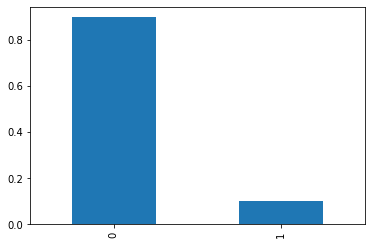

In [31]:
class_frequency = data['toxic'].value_counts(normalize= True)
print(class_frequency)
class_frequency.plot(kind='bar')

Наблюдается явный дисбаланс классов, однако, в дальнейшем я не буду реализовывать балансировку классов, поскольку так можно искусственно завысить качество модели, что может сбить с толку и тогда к заказчику отправится не лучшая модель.

На следующем этапе я обучу несколько моделей классификаторов - LogisticRegression(), RandomForestClassifier() и DecisionTreeClassifier(). Раннее я также обучила GradientBoostingClassifier(), однако модель продемонстрировала худшие результаты среди всех моделей - f1 = 0.6 при выборке n=80000, а также со временем обучения и кроссвалидации более часа без подбора гиперпараметров (подбор гиперпараметров шел более 7 часов). Поэтому, чтобы не тратить временные и энергетические ресурсы меня и заказчика, было принято решение ограничиться тремя моделями классификаторами.

Для начала следует обучить модели без подбора гиперпараметров и оценить с помощью кроссвалидации

In [32]:
regressors = [
    RandomForestClassifier(random_state = 12345),
    DecisionTreeClassifier(random_state = 12345),
    LogisticRegression()
]

In [33]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train_TFIDF, y_train)
    train_time = time() - start
    start = time()
    pred_train = model.predict(X_train_TFIDF)
    scores = cross_val_score(estimator = model, X=X_train_TFIDF, y=y_train, scoring='f1')
    final_score = sum(scores) / len(scores)
    predict_time = time()-start
    print(model)
    print("\tВремя обучения: %0.3fs" % train_time)
    print("\tВремя предсказания+оценка: %0.3fs" % predict_time)
    print('Средняя оценка качества модели:', final_score)
    print()

RandomForestClassifier(random_state=12345)
	Время обучения: 550.438s
	Время предсказания+оценка: 4677.484s
Средняя оценка качества модели: 0.6854021999078822

DecisionTreeClassifier(random_state=12345)
	Время обучения: 332.460s
	Время предсказания+оценка: 1304.955s
Средняя оценка качества модели: 0.7162266027486311

LogisticRegression()
	Время обучения: 45.153s
	Время предсказания+оценка: 223.086s
Средняя оценка качества модели: 0.7226394868769386



Ни одна из моделей не удовлетворяет условию заказчика, чтобы f1 была больше 0,75. Однако, следует проверить, не изменится ли ситуация после подбора оптимальных гиперпараметров (и ещё раз оценить логистическую регрессию). 

In [34]:
parameters_1 = {'max_depth' : (range(1, 7))}

In [35]:
%%time
grid = GridSearchCV(DecisionTreeClassifier(),parameters_1, scoring='f1', cv = 10)

model = grid.fit(X_train_TFIDF, y_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 6} 

0.5375296524240547 

CPU times: user 14min 3s, sys: 534 ms, total: 14min 3s
Wall time: 14min 4s


In [36]:
parameters_2 = {'n_estimators' : (range(10, 100, 10)),
              'max_depth' : (range(1, 7))
             }

In [37]:
%%time
grid = GridSearchCV(RandomForestClassifier(),parameters_2, scoring='f1', cv = 10)

model = grid.fit(X_train_TFIDF, y_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 1, 'n_estimators': 10} 

0.0 

CPU times: user 47min 43s, sys: 3.39 s, total: 47min 46s
Wall time: 47min 48s


In [38]:
%time clf = LogisticRegression(random_state=43).fit(X_train_TFIDF, y_train)

CPU times: user 19.9 s, sys: 26.8 s, total: 46.7 s
Wall time: 46.7 s


In [39]:
score = cross_val_score(estimator = clf, X=X_train_TFIDF, y=y_train, scoring='f1')

In [40]:
final_score = sum(score) / len(score)
final_score

0.7226394868769386

Таким образом, качество моделей DecisionTreeClassifier() и RandomForestClassifier() не повысилось несмотря на подбор гиперпараметром (возможно, в случае DecisionTreeClassifier() было слишком ограничено количество подбираемых ги перпараметров, олнако, следует помнить о специфике составлющих успешности кода в рамках данного проекта - это не только качество, но и время)

Лучшей моделью оказалась модель LogisticRegression(), а также оптимальная по времени обучения. Ее следует протестировать на тестовой выборке.

# Тестирование лучшей модели

In [41]:
%%time
model_1 = LogisticRegression(random_state=43)
model_1.fit(X_train_TFIDF, y_train)
predict_valid = model_1.predict(X_test_TFIDF)
print(f1_score(predict_valid, y_test))

0.7493520918178451
CPU times: user 21.4 s, sys: 25.5 s, total: 46.9 s
Wall time: 47 s


**Финальный вывод:**  

- Была проведена очистка текста от стоп-слов;
- Была проведена лемматизация текста;  
- Были приведены в порядок признаки, чтобы избежать утечки;
- Поскольку задачей проекта является предсказание класса комментария, то для этой задачи были обучены регрессионные модели RandomForestClassifier(), DecisionTreeClassifier() и LogisticRegression();
- Из этих моделей удовлетворяла условиям заказчика о допустимом пороге f1 только LogisticRegression(), которая и оказалась лучшей моделью и именно она была протестирована на тестовой выборке; 
- Модель LogisticRegression() на тестовой выборке так же удовлетворяет требованиям заказчика, а именно f1 = 0.750694058856191